# Logistic Regression
*Daniel Öman & Xander Yoon*

Import Dependencies

In [459]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Read database

In [275]:
path = "database.sqlite"
connection = sqlite3.connect(path)

# Data Cleaning and Feature Engineering

In [276]:
# Read Match data
matches = pd.read_sql("SELECT * FROM Match;", connection)

In [277]:
matches

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
for c in matches.columns:
    print(c)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

In [279]:
players = pd.read_sql("SELECT * FROM Player;", connection)

How to get a player in a matches starting lineup

In [280]:
players[players["player_api_id"] == matches["away_player_10"][25977]]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
1771,1774,92252,Christian Schneuwly,184285,1988-02-07 00:00:00,177.8,161


In [281]:
teams = pd.read_sql("SELECT * FROM Team_Attributes;", connection)

In [282]:
for c in teams.columns:
    print(c)

id
team_fifa_api_id
team_api_id
date
buildUpPlaySpeed
buildUpPlaySpeedClass
buildUpPlayDribbling
buildUpPlayDribblingClass
buildUpPlayPassing
buildUpPlayPassingClass
buildUpPlayPositioningClass
chanceCreationPassing
chanceCreationPassingClass
chanceCreationCrossing
chanceCreationCrossingClass
chanceCreationShooting
chanceCreationShootingClass
chanceCreationPositioningClass
defencePressure
defencePressureClass
defenceAggression
defenceAggressionClass
defenceTeamWidth
defenceTeamWidthClass
defenceDefenderLineClass


### Dataset preprocessing
For the binary classification problem, we will use "home team win" as the positive label and "home team draw/loss" as the negative label. We can extend this to three labels for a multi-class classification problem. Let's introduce this label to our dataset:

In [283]:
binary_class_label = "home_team_win"
binary_class_label_complement = "away_team_win"

In [284]:
matches[binary_class_label] = np.where(matches["home_team_goal"] - matches["away_team_goal"] > 0, 1, 0)
matches[binary_class_label_complement] = np.where(matches["home_team_win"] == 0, 1, 0)

In [285]:
# % of home wins in the dataset
num_home_wins = np.count_nonzero(matches["home_team_win"] == 1)
print(f"Percentage of home wins: {round(num_home_wins / matches.shape[0] * 100, 2)}%")

Percentage of home wins: 45.87%


### Helper functions

In [303]:
def train_test(table, test_size = 0.1):
    """
    Returns (train, test) of matches with a default 10% split
    """
    test = table.sample(frac = test_size, random_state = 200)
    train = table.drop(test.index)
    return train, test

def evaluate(y_true, y_pred, print_evaluators = True):
    """
    Helper to run different prediction evaluation functions
    """
    evaluators = {
        "rmse" : mean_squared_error(y_true, y_pred),
        "accuracy_score" : accuracy_score(y_true, y_pred) # Jaccard Index for binary classification
    }
    if print_evaluators:
        for name, evaluator in evaluators.items():
            print(f"{name} = {evaluator}")
    return evaluators

def logistic_regression(data, features, label = binary_class_label, test_size = 0.1, solver="newton-cholesky", print_evaluators = True):
    """
    Train logistic regression on dataset.
    Performs a test_size % split of train/test data
    Returns the model, training data, testing data, and the evaluators
    """
    train, test = train_test(data, test_size)
    lr = LogisticRegression(solver = solver)
    lr.fit(train[features], train[label])
    pred = lr.predict(test[features])
    evaluators = evaluate(test[label], pred, print_evaluators)
    return {"model": lr, "train_data": train, "test_data": test, "evaluators": evaluators}

# Model Training
1. Betting Odds
2. Team Match History
3. FIFA Attributes
4. Shape of formation

## 1. Betting Odds

We will use a logistic regression model trained on betting odds to predict match outcomes of a test dataset.

In [287]:
odds_columns = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

In [288]:
# Clean Data
odds_data = matches[odds_columns + [binary_class_label]].dropna()

Train the model.

In [305]:
odds_lr = logistic_regression(odds_data, odds_columns)

rmse = 0.30434782608695654
accuracy_score = 0.6956521739130435


## 2. Team Match History

Are historically successful teams more likely to win a matchup?

Look at all matches before a given match for a given team and compute their cumulative goal differential win rate. Encode a matchup as home cumulative goal difference/win rate - away cumulative goal difference/win rate

This is pretty difficult...

## 3. FIFA Attributes

Use aggregated FIFA information from Team_Attributes to predict match outcomes.

In [290]:
team_attributes = pd.read_sql("SELECT * FROM Team_Attributes;", connection)

In [397]:
# Features to train the model on
buildup_features = ["buildUpPlaySpeed", "buildUpPlayDribbling", "buildUpPlayPassing"]
chance_creation_features = ["chanceCreationPassing", "chanceCreationCrossing", "chanceCreationShooting"]
defence_features = ["defencePressure", "defenceAggression", "defenceTeamWidth"]
categories = [buildup_features, chance_creation_features, defence_features]

aggregations = ["mean", "min", "max", "median"]

# Raw names
all_attr_features = []
for category in categories:
    all_attr_features += category

# Named aggregations
all_attr_features_agg = []
categories_agg = []
for category in categories:
    category_agg = []
    for agg in aggregations:
        for feature in category:
            formatted_feature_name = f"{feature}_{agg}"
            category_agg.append(formatted_feature_name)
            all_attr_features_agg.append(formatted_feature_name)
    categories_agg.append(category_agg)

len(all_attr_features_agg)

36

In [413]:
aggregated_attributes = team_attributes.groupby("team_api_id").agg(
    {feature : [(f"{feature}_{agg}", agg) for agg in aggregations]for feature in all_attr_features}
).reset_index(col_level = 1).droplevel(level = 0, axis = 1)[["team_api_id"] + all_attr_features_agg]

aggregated_attributes.head()

,team_api_id,buildUpPlaySpeed_mean,buildUpPlayDribbling_mean,buildUpPlayPassing_mean,buildUpPlaySpeed_min,buildUpPlayDribbling_min,buildUpPlayPassing_min,buildUpPlaySpeed_max,buildUpPlayDribbling_max,buildUpPlayPassing_max,...,defenceTeamWidth_mean,defencePressure_min,defenceAggression_min,defenceTeamWidth_min,defencePressure_max,defenceAggression_max,defenceTeamWidth_max,defencePressure_median,defenceAggression_median,defenceTeamWidth_median
0,1601,47.333333,48.0,46.166667,30,48.0,38,53,48.0,55,...,49.333333,43,44,49,65,60,50,43.0,44.0,49.0
1,1773,52.000000,51.0,50.000000,52,51.0,50,52,51.0,50,...,50.000000,43,44,50,43,44,50,43.0,44.0,50.0
2,1957,47.166667,54.0,52.666667,30,54.0,38,66,54.0,69,...,53.666667,32,50,49,70,70,70,48.5,56.0,51.0
3,2033,49.000000,62.0,48.400000,45,62.0,40,65,62.0,55,...,45.400000,37,24,35,50,45,60,37.0,31.0,44.0
4,2182,60.333333,52.5,49.000000,40,50.0,35,67,55.0,57,...,54.500000,47,37,45,60,58,63,48.5,47.0,55.5


In [404]:
def attribute_matchup(dataset, home_id, away_id):
    """
    Computes the matchup features for the home_id and away_id.
    """
    home = dataset[dataset["team_api_id"] == home_id][all_attr_features_agg].to_numpy()
    away = dataset[dataset["team_api_id"] == away_id][all_attr_features_agg].to_numpy()
    if len(home) == 0 or len(away) == 0:
        # Team not present, no matchup possible
        return pd.Series([np.nan] * len(all_attr_features_agg), index = all_attr_features_agg)
    diff = (home - away)[0]
    return pd.Series(diff, index = all_attr_features_agg)

Generate team attribute matchups. This cell took around 1 minute

In [405]:
attr_data = matches.copy()
attr_data[all_attr_features_agg] = attr_data.apply(lambda x: attribute_matchup(aggregated_attributes, x["home_team_api_id"], x["away_team_api_id"]), axis = 1, result_type = "expand")

In [408]:
attr_data = attr_data.dropna()
attr_data.shape

(1762, 153)

Train the model using all features

In [409]:
attr_lr = logistic_regression(attr_data, all_attr_features_agg)

rmse = 0.44886363636363635
accuracy_score = 0.5511363636363636


Train per category

In [410]:
print("*** Buildup Play Features ***")
buildup_lr = logistic_regression(attr_data, categories_agg[0])
print("*** Chance Creation Features ***")
chance_creation_lr = logistic_regression(attr_data, categories_agg[1])
print("*** Defensive Play Features ***")
defence_lr = logistic_regression(attr_data, categories_agg[2])

*** Buildup Play Features ***
rmse = 0.42613636363636365
accuracy_score = 0.5738636363636364
*** Chance Creation Features ***
rmse = 0.4090909090909091
accuracy_score = 0.5909090909090909
*** Defensive Play Features ***
rmse = 0.5113636363636364
accuracy_score = 0.48863636363636365


Investigate best aggregation technique:

In [415]:
# Train using only mean chance creation
lrs = []
for aggregation in aggregations:
    print(f"*** {aggregation} ***")
    lrs.append(logistic_regression(attr_data, [f"{feature}_{aggregation}" for feature in chance_creation_features]))

*** mean ***
rmse = 0.44886363636363635
accuracy_score = 0.5511363636363636
*** min ***
rmse = 0.4318181818181818
accuracy_score = 0.5681818181818182
*** max ***
rmse = 0.375
accuracy_score = 0.625
*** median ***
rmse = 0.45454545454545453
accuracy_score = 0.5454545454545454


Max seems to be the best-performing aggregation. Pick the top 2 best performing features and retrain

In [453]:
max_cr_features = [f"{feature}_max" for feature in chance_creation_features]
# By trial and error 1 and 2 are the best
max_cr_features = [max_cr_features[1], max_cr_features[2]]

chance_creation_max_lr = logistic_regression(attr_data, max_cr_features)

test = chance_creation_max_lr["test_data"]
y_pred = chance_creation_max_lr["model"].predict(test[max_cr_features])

rmse = 0.3806818181818182
accuracy_score = 0.6193181818181818


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'z-axis(predictions)')

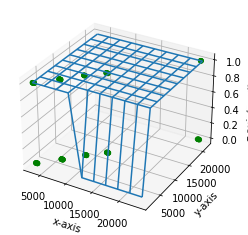

In [466]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# to just see the prediction results of your data
ax.scatter(test.iloc[:, 0], test.iloc[:, 1], y_pred, c='g')

samples = 10
xx, yy = np.meshgrid(np.linspace(min(test.iloc[:,0]), max(test.iloc[:,0]), samples), np.linspace(min(test.iloc[:,1]), max(test.iloc[:,1]), samples))
ax.plot_wireframe(xx, yy, chance_creation_max_lr["model"].predict(np.hstack((xx.reshape(-1,1), yy.reshape(-1,1)))).reshape(xx.shape))
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis(predictions)')

## 4. Formation shape
Use unsupervised learning to categorize formations into narrow/wide, defensive/attacking, output "formation width index" and "formation aggressiveness index"